# Face Generation with GANs

* [Step 1](#step1): Reading the CelebA dataset
* [Step 2](#step2): Building inputs to the networks
* [Step 3](#step3): Building the Discriminator Network
* [Step 4](#step4): Building the Generator Network
* [Step 5](#step5): Putting all together
* [Step 6](#step6): Training
* [Step 7](#step7): Viewing Results

<a id='step1'></a>
## Step 1: Reading the CelebA dataset

In [5]:
import helper

data_dir = 'data/'
helper.download_extract('celeba', data_dir)

Extracting celeba...


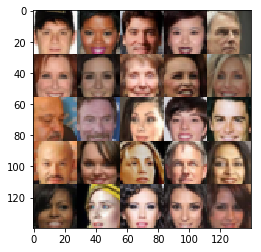

In [8]:
#viewing some images
import os
from glob import glob
from matplotlib import pyplot

show_n_images = 25
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

<a id='step2'></a>
## Step 2: Building inputs to the networks 

In [11]:
import tensorflow as tf
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    input_real_placeholder = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z_placeholder = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate_placeholder = tf.placeholder(tf.float32, name='lr')
    
    return input_real_placeholder, input_z_placeholder, learning_rate_placeholder

<a id='step3'></a>
## Step 3: Build the discriminator Network

In [15]:
def discriminator(images, reuse=False):
    dropout = 0.8
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28
        init_conv_layer1 = tf.contrib.layers.xavier_initializer()
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=init_conv_layer1)
        relu1 = tf.maximum(x1, alpha*x1)
        drop1 = tf.nn.dropout(relu1, dropout)
        
        #14x14x64
        init_conv_layer2 = tf.contrib.layers.xavier_initializer()
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same', kernel_initializer=init_conv_layer2)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2, alpha*bn2)
        drop2 = tf.nn.dropout(relu2, dropout)
        
        #7x7x128
        init_conv_layer3 = tf.contrib.layers.xavier_initializer()
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same', kernel_initializer=init_conv_layer3)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3, alpha*bn3)
        drop3 = tf.nn.dropout(relu3, dropout)
        
        #4x4x256
        init_conv_layer4 = tf.contrib.layers.xavier_initializer()
        x4 = tf.layers.conv2d(drop3, 512, 5, strides=1, padding='same', kernel_initializer=init_conv_layer4)
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(bn4, alpha*bn4)
        drop4 = tf.nn.dropout(relu4, dropout)
        
        #4x4x512
        flat = tf.reshape(drop4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return logits, output

<a id='step4'></a>
## Step 4: Building the Generator Network

In [18]:
def generator(z, out_channel_dim, is_train=True):
    dropout = 0.8
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        init_layer1 = tf.contrib.layers.xavier_initializer()
        x1 = tf.layers.dense(z, 7*7*512, kernel_initializer=init_layer1)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(bn1, alpha*bn1)
        drop1 = tf.nn.dropout(relu1, dropout)
        
        #7x7x512
        init_layer2 = tf.contrib.layers.xavier_initializer()
        x2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=2, padding='same', kernel_initializer=init_layer2)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(bn2, alpha*bn2)
        drop2 = tf.nn.dropout(relu2, dropout)
        
        #14x14x256
        init_layer3 = tf.contrib.layers.xavier_initializer()
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=2, padding='same', kernel_initializer=init_layer3)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(bn3, alpha*bn3)
        drop3 = tf.nn.dropout(relu3, dropout)
        
        #28x28x128
        init_layer4 = tf.contrib.layers.xavier_initializer()
        x4 = tf.layers.conv2d_transpose(drop3, 64, 5, strides=1, padding='same', kernel_initializer=init_layer4)
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(bn4, alpha*bn4)
        drop4 = tf.nn.dropout(relu4, dropout)
        
        #28x28x64
        init_layer5 = tf.contrib.layers.xavier_initializer()
        x5 = tf.layers.conv2d_transpose(drop4, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=init_layer5)
        
        # 28x28xout_channel_dim
        output = tf.tanh(x5)
        
        return output

<a id='step5'></a>
## Step 5: Putting  all together

In [20]:
#Defining the loss
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim)
    d_logits_real, d_model_real = discriminator(input_real)
    d_logits_fake, d_model_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

In [25]:
#defininf the optmizers
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

In [22]:
#function to show the outpu
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

<a id='step6'></a>
## Step 6: Training 

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    image_channels = 3
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate:learning_rate})

                if steps % 50 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
        
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                steps += 1

Epoch 1/3... Discriminator Loss: 10.0356... Generator Loss: 0.0012


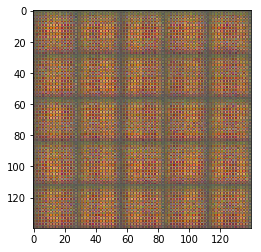

Epoch 1/3... Discriminator Loss: 1.6539... Generator Loss: 1.1733
Epoch 1/3... Discriminator Loss: 1.2699... Generator Loss: 0.6690
Epoch 1/3... Discriminator Loss: 0.7772... Generator Loss: 3.0670
Epoch 1/3... Discriminator Loss: 1.1285... Generator Loss: 0.9840
Epoch 1/3... Discriminator Loss: 1.6547... Generator Loss: 0.3850
Epoch 1/3... Discriminator Loss: 2.0523... Generator Loss: 2.6276
Epoch 1/3... Discriminator Loss: 1.1465... Generator Loss: 1.1100
Epoch 1/3... Discriminator Loss: 1.1806... Generator Loss: 0.7011
Epoch 1/3... Discriminator Loss: 1.3218... Generator Loss: 0.9851
Epoch 1/3... Discriminator Loss: 1.3512... Generator Loss: 0.7426


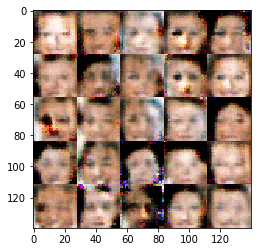

Epoch 1/3... Discriminator Loss: 1.2970... Generator Loss: 1.0088
Epoch 1/3... Discriminator Loss: 1.3892... Generator Loss: 1.1542
Epoch 1/3... Discriminator Loss: 1.3945... Generator Loss: 0.6627
Epoch 1/3... Discriminator Loss: 1.2838... Generator Loss: 0.6458
Epoch 1/3... Discriminator Loss: 1.3602... Generator Loss: 1.2491
Epoch 1/3... Discriminator Loss: 1.2655... Generator Loss: 1.8403
Epoch 1/3... Discriminator Loss: 1.4158... Generator Loss: 0.6638
Epoch 1/3... Discriminator Loss: 1.3714... Generator Loss: 1.2395
Epoch 1/3... Discriminator Loss: 1.3409... Generator Loss: 0.9442
Epoch 1/3... Discriminator Loss: 1.3589... Generator Loss: 0.5460


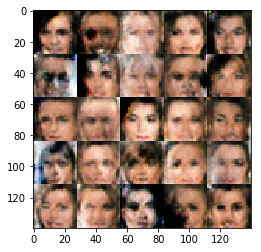

Epoch 1/3... Discriminator Loss: 1.2073... Generator Loss: 0.8836
Epoch 1/3... Discriminator Loss: 1.2512... Generator Loss: 1.0495
Epoch 1/3... Discriminator Loss: 1.3989... Generator Loss: 0.6640
Epoch 1/3... Discriminator Loss: 1.3773... Generator Loss: 0.6425
Epoch 1/3... Discriminator Loss: 1.3872... Generator Loss: 0.7236
Epoch 1/3... Discriminator Loss: 1.2382... Generator Loss: 0.8280
Epoch 1/3... Discriminator Loss: 1.4289... Generator Loss: 0.9548
Epoch 1/3... Discriminator Loss: 1.2578... Generator Loss: 1.0001
Epoch 1/3... Discriminator Loss: 1.2966... Generator Loss: 0.9887
Epoch 1/3... Discriminator Loss: 1.3737... Generator Loss: 0.8588


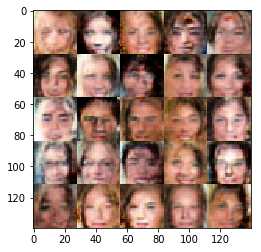

Epoch 1/3... Discriminator Loss: 1.4000... Generator Loss: 0.6567
Epoch 1/3... Discriminator Loss: 1.2210... Generator Loss: 0.7361
Epoch 1/3... Discriminator Loss: 1.2806... Generator Loss: 0.9138
Epoch 1/3... Discriminator Loss: 1.3793... Generator Loss: 0.6761
Epoch 1/3... Discriminator Loss: 1.2347... Generator Loss: 0.7921
Epoch 1/3... Discriminator Loss: 1.2373... Generator Loss: 0.8701
Epoch 1/3... Discriminator Loss: 1.4503... Generator Loss: 0.8350
Epoch 1/3... Discriminator Loss: 1.3636... Generator Loss: 0.7537
Epoch 1/3... Discriminator Loss: 1.3284... Generator Loss: 0.9310
Epoch 1/3... Discriminator Loss: 1.3821... Generator Loss: 0.6931


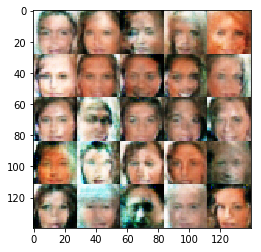

Epoch 1/3... Discriminator Loss: 1.2963... Generator Loss: 0.8797
Epoch 1/3... Discriminator Loss: 1.2477... Generator Loss: 0.9252
Epoch 1/3... Discriminator Loss: 1.2872... Generator Loss: 0.8163
Epoch 1/3... Discriminator Loss: 1.3913... Generator Loss: 1.1440
Epoch 1/3... Discriminator Loss: 1.3155... Generator Loss: 0.8901
Epoch 1/3... Discriminator Loss: 1.5348... Generator Loss: 0.8872
Epoch 1/3... Discriminator Loss: 1.3629... Generator Loss: 1.0167
Epoch 1/3... Discriminator Loss: 1.5122... Generator Loss: 0.6203
Epoch 1/3... Discriminator Loss: 1.3140... Generator Loss: 0.8219
Epoch 1/3... Discriminator Loss: 1.2993... Generator Loss: 0.7366


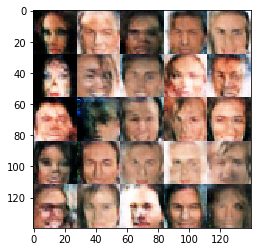

Epoch 1/3... Discriminator Loss: 1.4380... Generator Loss: 0.6380
Epoch 1/3... Discriminator Loss: 1.2577... Generator Loss: 0.7492
Epoch 1/3... Discriminator Loss: 1.3581... Generator Loss: 0.8047
Epoch 1/3... Discriminator Loss: 1.3591... Generator Loss: 0.9539
Epoch 1/3... Discriminator Loss: 1.4391... Generator Loss: 0.8449
Epoch 1/3... Discriminator Loss: 1.3813... Generator Loss: 0.9021
Epoch 1/3... Discriminator Loss: 1.4342... Generator Loss: 0.7310
Epoch 1/3... Discriminator Loss: 1.3322... Generator Loss: 0.8081
Epoch 1/3... Discriminator Loss: 1.2789... Generator Loss: 0.8261
Epoch 1/3... Discriminator Loss: 1.4953... Generator Loss: 0.7105


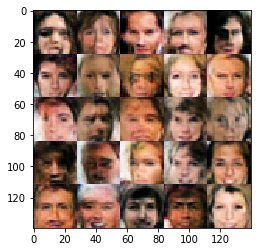

Epoch 1/3... Discriminator Loss: 1.3301... Generator Loss: 1.0017
Epoch 1/3... Discriminator Loss: 1.2307... Generator Loss: 0.8698
Epoch 1/3... Discriminator Loss: 1.2986... Generator Loss: 0.7977
Epoch 2/3... Discriminator Loss: 1.3808... Generator Loss: 0.8530
Epoch 2/3... Discriminator Loss: 1.3090... Generator Loss: 0.8312
Epoch 2/3... Discriminator Loss: 1.3448... Generator Loss: 0.7065
Epoch 2/3... Discriminator Loss: 1.3500... Generator Loss: 0.7361
Epoch 2/3... Discriminator Loss: 1.3074... Generator Loss: 0.8980
Epoch 2/3... Discriminator Loss: 1.2539... Generator Loss: 0.9116
Epoch 2/3... Discriminator Loss: 1.3655... Generator Loss: 0.7750


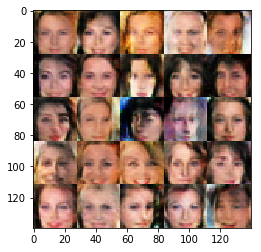

Epoch 2/3... Discriminator Loss: 1.3582... Generator Loss: 0.8711
Epoch 2/3... Discriminator Loss: 1.4066... Generator Loss: 0.8177
Epoch 2/3... Discriminator Loss: 1.2681... Generator Loss: 0.9382
Epoch 2/3... Discriminator Loss: 1.3646... Generator Loss: 0.8166
Epoch 2/3... Discriminator Loss: 1.3363... Generator Loss: 0.8386
Epoch 2/3... Discriminator Loss: 1.3574... Generator Loss: 0.9697
Epoch 2/3... Discriminator Loss: 1.3391... Generator Loss: 0.9065
Epoch 2/3... Discriminator Loss: 1.3634... Generator Loss: 0.8449
Epoch 2/3... Discriminator Loss: 1.3581... Generator Loss: 0.6780
Epoch 2/3... Discriminator Loss: 1.2971... Generator Loss: 0.8589


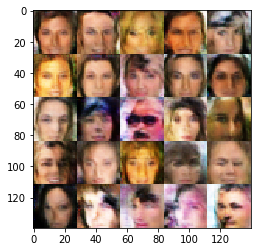

Epoch 2/3... Discriminator Loss: 1.3148... Generator Loss: 0.8453
Epoch 2/3... Discriminator Loss: 1.3776... Generator Loss: 0.7365
Epoch 2/3... Discriminator Loss: 1.3167... Generator Loss: 0.8765
Epoch 2/3... Discriminator Loss: 1.3304... Generator Loss: 0.9417
Epoch 2/3... Discriminator Loss: 1.3853... Generator Loss: 0.7775
Epoch 2/3... Discriminator Loss: 1.4349... Generator Loss: 0.8607
Epoch 2/3... Discriminator Loss: 1.4275... Generator Loss: 0.7582
Epoch 2/3... Discriminator Loss: 1.2618... Generator Loss: 0.7978
Epoch 2/3... Discriminator Loss: 1.2796... Generator Loss: 0.6562
Epoch 2/3... Discriminator Loss: 1.3925... Generator Loss: 0.7667


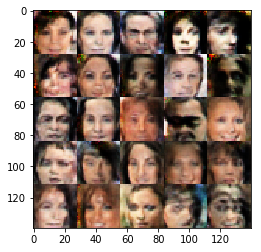

Epoch 2/3... Discriminator Loss: 1.4076... Generator Loss: 1.0662
Epoch 2/3... Discriminator Loss: 1.3535... Generator Loss: 0.7060
Epoch 2/3... Discriminator Loss: 1.3938... Generator Loss: 0.9263
Epoch 2/3... Discriminator Loss: 1.3682... Generator Loss: 0.7472
Epoch 2/3... Discriminator Loss: 1.3960... Generator Loss: 0.7843
Epoch 2/3... Discriminator Loss: 1.3232... Generator Loss: 0.8937
Epoch 2/3... Discriminator Loss: 1.3963... Generator Loss: 0.6877
Epoch 2/3... Discriminator Loss: 1.3626... Generator Loss: 0.8806
Epoch 2/3... Discriminator Loss: 1.3247... Generator Loss: 0.7462
Epoch 2/3... Discriminator Loss: 1.3580... Generator Loss: 0.8174


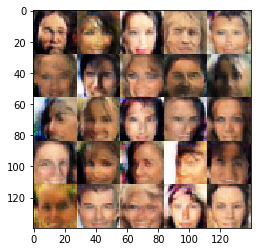

Epoch 2/3... Discriminator Loss: 1.3938... Generator Loss: 0.8129
Epoch 2/3... Discriminator Loss: 1.3278... Generator Loss: 0.8273
Epoch 2/3... Discriminator Loss: 1.3757... Generator Loss: 0.8797
Epoch 2/3... Discriminator Loss: 1.3481... Generator Loss: 0.7969
Epoch 2/3... Discriminator Loss: 1.3627... Generator Loss: 0.8537
Epoch 2/3... Discriminator Loss: 1.3294... Generator Loss: 0.8529
Epoch 2/3... Discriminator Loss: 1.4019... Generator Loss: 0.8016
Epoch 2/3... Discriminator Loss: 1.3030... Generator Loss: 0.7877
Epoch 2/3... Discriminator Loss: 1.4347... Generator Loss: 0.7821
Epoch 2/3... Discriminator Loss: 1.2640... Generator Loss: 0.8749


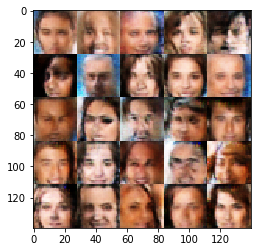

Epoch 2/3... Discriminator Loss: 1.3472... Generator Loss: 0.8230
Epoch 2/3... Discriminator Loss: 1.3500... Generator Loss: 0.8741
Epoch 2/3... Discriminator Loss: 1.3661... Generator Loss: 0.7570
Epoch 2/3... Discriminator Loss: 1.3052... Generator Loss: 0.8897
Epoch 2/3... Discriminator Loss: 1.3807... Generator Loss: 0.7058
Epoch 2/3... Discriminator Loss: 1.3852... Generator Loss: 0.8211
Epoch 2/3... Discriminator Loss: 1.3588... Generator Loss: 0.8978
Epoch 2/3... Discriminator Loss: 1.4105... Generator Loss: 0.7079
Epoch 2/3... Discriminator Loss: 1.2967... Generator Loss: 0.7318
Epoch 2/3... Discriminator Loss: 1.4048... Generator Loss: 0.8976


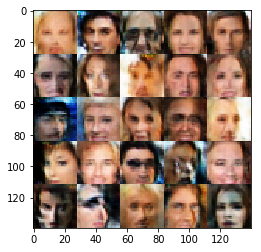

Epoch 2/3... Discriminator Loss: 1.4073... Generator Loss: 1.0094
Epoch 2/3... Discriminator Loss: 1.3086... Generator Loss: 0.7850
Epoch 2/3... Discriminator Loss: 1.3629... Generator Loss: 0.7841
Epoch 2/3... Discriminator Loss: 1.3316... Generator Loss: 0.7710
Epoch 2/3... Discriminator Loss: 1.3477... Generator Loss: 0.8116
Epoch 2/3... Discriminator Loss: 1.3289... Generator Loss: 0.7942
Epoch 3/3... Discriminator Loss: 1.3109... Generator Loss: 0.7873
Epoch 3/3... Discriminator Loss: 1.3859... Generator Loss: 0.8203
Epoch 3/3... Discriminator Loss: 1.3670... Generator Loss: 0.9051
Epoch 3/3... Discriminator Loss: 1.4526... Generator Loss: 0.6669


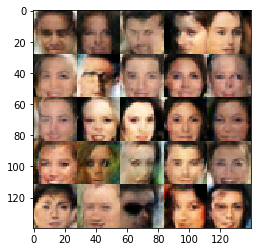

Epoch 3/3... Discriminator Loss: 1.3585... Generator Loss: 0.7308
Epoch 3/3... Discriminator Loss: 1.3201... Generator Loss: 0.7266
Epoch 3/3... Discriminator Loss: 1.4036... Generator Loss: 0.8236
Epoch 3/3... Discriminator Loss: 1.3738... Generator Loss: 0.8210
Epoch 3/3... Discriminator Loss: 1.3757... Generator Loss: 0.9067
Epoch 3/3... Discriminator Loss: 1.3791... Generator Loss: 0.8465
Epoch 3/3... Discriminator Loss: 1.2647... Generator Loss: 0.6789
Epoch 3/3... Discriminator Loss: 0.7923... Generator Loss: 1.3191
Epoch 3/3... Discriminator Loss: 1.0742... Generator Loss: 1.0002
Epoch 3/3... Discriminator Loss: 1.2550... Generator Loss: 0.9750


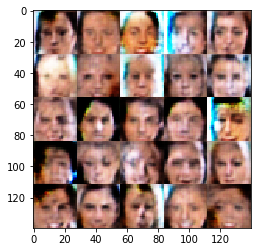

Epoch 3/3... Discriminator Loss: 1.0558... Generator Loss: 1.0493
Epoch 3/3... Discriminator Loss: 1.0729... Generator Loss: 1.0896
Epoch 3/3... Discriminator Loss: 1.4501... Generator Loss: 0.7772
Epoch 3/3... Discriminator Loss: 1.2392... Generator Loss: 1.1126
Epoch 3/3... Discriminator Loss: 1.1127... Generator Loss: 1.0478
Epoch 3/3... Discriminator Loss: 1.2177... Generator Loss: 0.9373
Epoch 3/3... Discriminator Loss: 1.2729... Generator Loss: 0.9123
Epoch 3/3... Discriminator Loss: 1.3183... Generator Loss: 0.9721
Epoch 3/3... Discriminator Loss: 1.3454... Generator Loss: 0.7696
Epoch 3/3... Discriminator Loss: 1.3467... Generator Loss: 1.0603


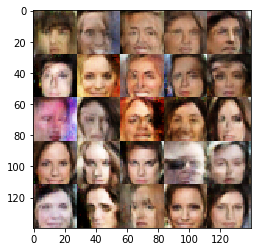

Epoch 3/3... Discriminator Loss: 1.2952... Generator Loss: 0.9395
Epoch 3/3... Discriminator Loss: 1.2823... Generator Loss: 0.6958
Epoch 3/3... Discriminator Loss: 1.4213... Generator Loss: 0.7924
Epoch 3/3... Discriminator Loss: 1.3667... Generator Loss: 0.8910
Epoch 3/3... Discriminator Loss: 1.2608... Generator Loss: 0.8787
Epoch 3/3... Discriminator Loss: 1.2344... Generator Loss: 0.8152
Epoch 3/3... Discriminator Loss: 1.2163... Generator Loss: 1.2374
Epoch 3/3... Discriminator Loss: 1.3399... Generator Loss: 0.7758
Epoch 3/3... Discriminator Loss: 1.3748... Generator Loss: 0.8808
Epoch 3/3... Discriminator Loss: 1.4503... Generator Loss: 0.6811


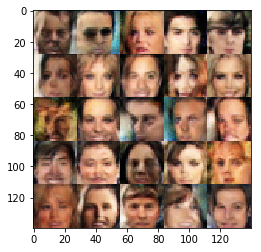

Epoch 3/3... Discriminator Loss: 1.2164... Generator Loss: 0.9032
Epoch 3/3... Discriminator Loss: 1.3375... Generator Loss: 0.8871
Epoch 3/3... Discriminator Loss: 1.2143... Generator Loss: 0.8065
Epoch 3/3... Discriminator Loss: 1.3939... Generator Loss: 0.7481
Epoch 3/3... Discriminator Loss: 1.2992... Generator Loss: 0.8461
Epoch 3/3... Discriminator Loss: 1.1163... Generator Loss: 0.8701
Epoch 3/3... Discriminator Loss: 1.2220... Generator Loss: 0.8608
Epoch 3/3... Discriminator Loss: 1.1745... Generator Loss: 0.7585
Epoch 3/3... Discriminator Loss: 1.3146... Generator Loss: 0.8048
Epoch 3/3... Discriminator Loss: 1.2889... Generator Loss: 0.7594


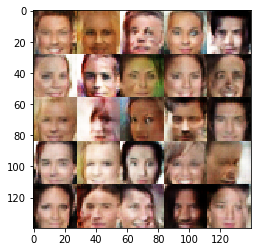

Epoch 3/3... Discriminator Loss: 1.3627... Generator Loss: 0.7480
Epoch 3/3... Discriminator Loss: 1.3457... Generator Loss: 0.8338
Epoch 3/3... Discriminator Loss: 1.2051... Generator Loss: 0.8415
Epoch 3/3... Discriminator Loss: 1.3527... Generator Loss: 0.7461
Epoch 3/3... Discriminator Loss: 1.2713... Generator Loss: 0.8018
Epoch 3/3... Discriminator Loss: 1.2462... Generator Loss: 0.7889
Epoch 3/3... Discriminator Loss: 1.1386... Generator Loss: 0.9214
Epoch 3/3... Discriminator Loss: 1.3103... Generator Loss: 0.8255
Epoch 3/3... Discriminator Loss: 1.1137... Generator Loss: 0.9782
Epoch 3/3... Discriminator Loss: 1.3809... Generator Loss: 0.5631


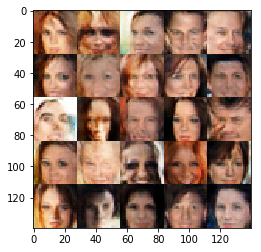

Epoch 3/3... Discriminator Loss: 1.3528... Generator Loss: 0.8815
Epoch 3/3... Discriminator Loss: 1.3533... Generator Loss: 0.9497
Epoch 3/3... Discriminator Loss: 1.3396... Generator Loss: 0.8617
Epoch 3/3... Discriminator Loss: 1.3101... Generator Loss: 0.8553
Epoch 3/3... Discriminator Loss: 1.3900... Generator Loss: 0.8887
Epoch 3/3... Discriminator Loss: 1.2593... Generator Loss: 0.8143
Epoch 3/3... Discriminator Loss: 1.2762... Generator Loss: 0.7874
Epoch 3/3... Discriminator Loss: 1.3496... Generator Loss: 0.9699
Epoch 3/3... Discriminator Loss: 1.2480... Generator Loss: 0.8224


In [33]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.4
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)